# Transfer Learning

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18,6)

In [23]:
import os
import glob
import zipfile
import functools



## LOAD ALL PICS DOG & CATS FROM ANIMALS TRAIN FOLDER

In [24]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)

In [25]:
files = glob.glob('50images/Train/*')

cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files), len(dog_files)

(50, 50)

## Select 30 pics for train sample, 10 validation sample, 10 for test sample

In [26]:
cat_train = np.random.choice(cat_files, size=30, replace=False)
dog_train = np.random.choice(dog_files, size=30, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=10, replace=False)
dog_val = np.random.choice(dog_files, size=10, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=10, replace=False)
dog_test = np.random.choice(dog_files, size=10, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (30,) (10,) (10,)
Dog datasets: (30,) (10,) (10,)


## Lets put this samples into train, validation and test folders

In [27]:
train_dir = '50training_data'
val_dir = '50validation_data'
test_dir = '50test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

In [28]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

In [29]:
import os
os.sep

'\\'

## Load each folder on RAM MEMORY

In [30]:
IMG_DIM = (150, 150)

train_files = glob.glob('50training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split(os.sep)[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('50validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split(os.sep)[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (60, 150, 150, 3) 	Validation dataset shape: (35, 150, 150, 3)


## Allways need scale(normalization): generating a better performance

(150, 150, 3)


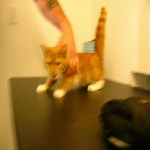

In [31]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

## Encoding LABEL prectitions using One Hot Encoding

In [32]:
batch_size = 5
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[25:35], train_labels_enc[25:35])

['cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog'] [0 0 0 0 0 1 1 1 1 1]


## Model 1: using Convolution Layers without Dropout

In [33]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 36992)            

In [34]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 60 samples, validate on 35 samples
Epoch 1/30
60/60 [==============================] - 3s 49ms/step - loss: 1.6739 - accuracy: 0.5000 - val_loss: 0.6881 - val_accuracy: 0.6286
Epoch 2/30
60/60 [==============================] - 2s 36ms/step - loss: 0.7224 - accuracy: 0.5167 - val_loss: 0.7065 - val_accuracy: 0.4571
Epoch 3/30
60/60 [==============================] - 2s 35ms/step - loss: 0.7395 - accuracy: 0.5667 - val_loss: 2.4902 - val_accuracy: 0.4571
Epoch 4/30
60/60 [==============================] - 2s 36ms/step - loss: 0.6554 - accuracy: 0.7833 - val_loss: 0.6890 - val_accuracy: 0.4857
Epoch 5/30
60/60 [==============================] - 2s 36ms/step - loss: 0.4763 - accuracy: 0.7833 - val_loss: 0.6532 - val_accuracy: 0.5429
Epoch 6/30
60/60 [==============================] - 2s 36ms/step - loss: 0.5258 - accuracy: 0.8667 - val_loss: 0.8084 - val_accuracy: 0.5143
Epoch 7/30
60/60 [==============================] - 2s 36ms/step - loss: 0.4035 - accuracy: 0.8667 - val_loss:

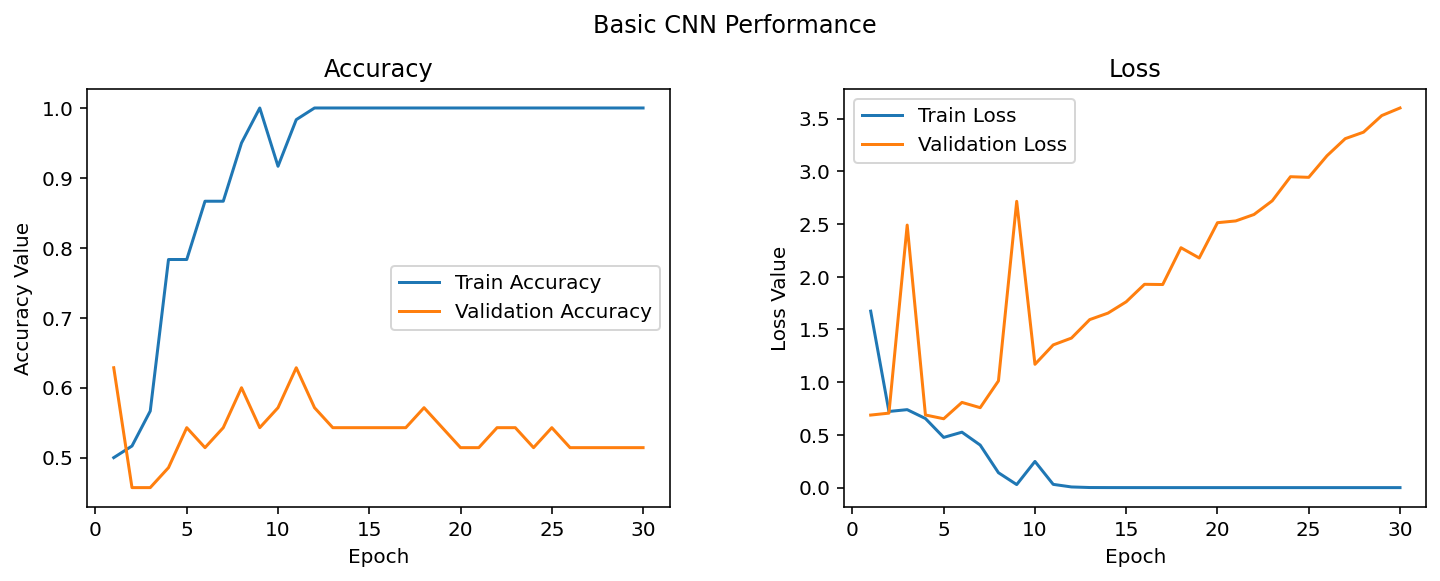

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Saving Model

In [36]:
model.save('50cats_dogs_basic_without_dropout.h5')

## Model 2 CNN with Dropout layers

In [37]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])
              
              
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1) 

Train on 60 samples, validate on 35 samples
Epoch 1/30
60/60 [==============================] - 3s 50ms/step - loss: 1.2202 - accuracy: 0.4333 - val_loss: 0.6897 - val_accuracy: 0.5429
Epoch 2/30
60/60 [==============================] - 2s 34ms/step - loss: 0.8279 - accuracy: 0.4833 - val_loss: 0.6898 - val_accuracy: 0.5429
Epoch 3/30
60/60 [==============================] - 2s 34ms/step - loss: 0.6974 - accuracy: 0.4667 - val_loss: 0.6911 - val_accuracy: 0.5429
Epoch 4/30
60/60 [==============================] - 2s 35ms/step - loss: 0.7509 - accuracy: 0.5167 - val_loss: 0.6918 - val_accuracy: 0.5429
Epoch 5/30
60/60 [==============================] - 2s 34ms/step - loss: 0.6988 - accuracy: 0.4333 - val_loss: 0.6914 - val_accuracy: 0.4857
Epoch 6/30
60/60 [==============================] - 2s 34ms/step - loss: 0.6968 - accuracy: 0.5833 - val_loss: 0.7235 - val_accuracy: 0.4571
Epoch 7/30
60/60 [==============================] - 2s 34ms/step - loss: 0.6550 - accuracy: 0.6167 - val_loss:

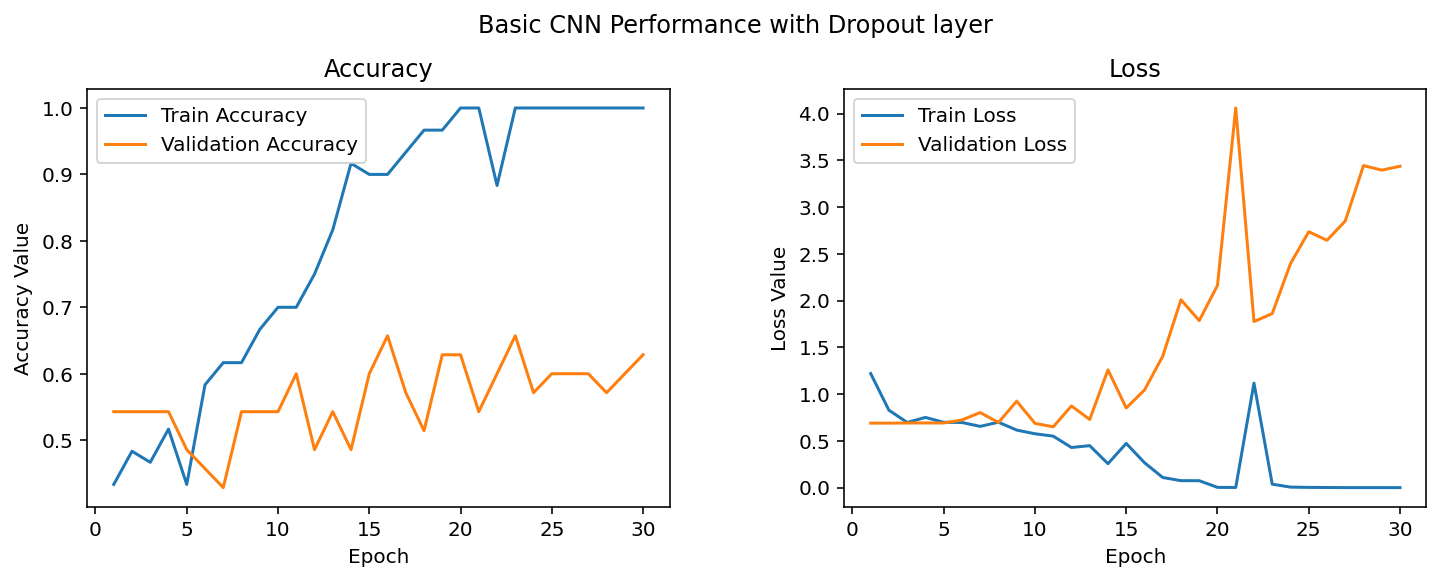

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance with Dropout layer', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [39]:
model.save('50cats_dogs_basic_cnn.h5')

## Building Data Augmentation Generator to reduce VARIANCE

In [40]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['dog', 'dog', 'dog', 'dog', 'dog']


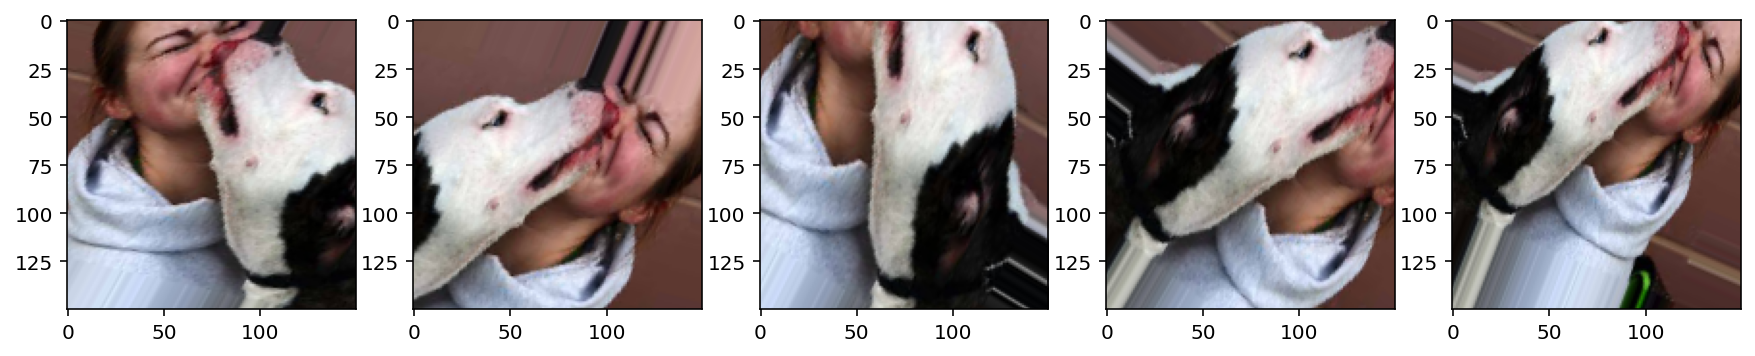

In [41]:
img_id = 51
dog_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in dog])
l = [ax[i].imshow(dog[i][0][0]) for i in range(0,5)]

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


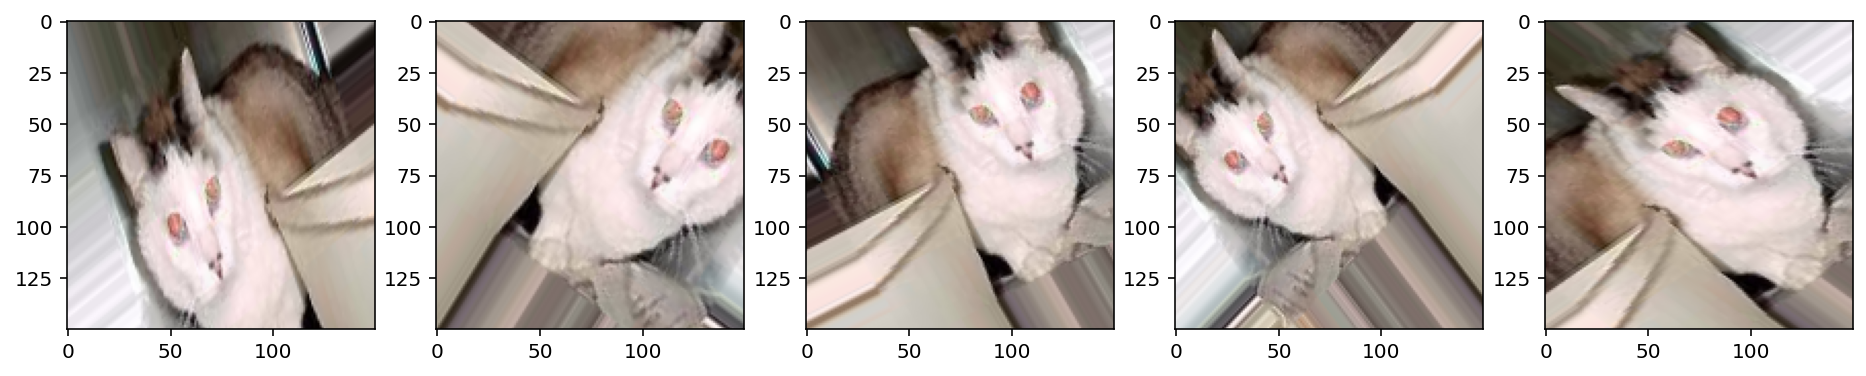

In [42]:
img_id = 25
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

## Model 3: CNN with Dropout layers using Data Augmentation Generator

In [43]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=5)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=3)
input_shape = (150, 150, 3)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
              
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=8, 
                              verbose=1) 

Epoch 1/100
100/100 [==============================] - 16s 160ms/step - loss: 0.7003 - accuracy: 0.4700 - val_loss: 0.7592 - val_accuracy: 0.5000
Epoch 2/100
 95/100 [===========================>..] - ETA: 0s - loss: 0.6965 - accuracy: 0.4632

KeyboardInterrupt: 

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN with Dropout layer using Data Augumentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.save('50cats_dogs_cnn_img_aug.h5')

## Using a VGG16 pre-trained model, adding new outout layers (Transfer Learning)

In [70]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

Layer Type  \
0   <keras.engine.input_layer.InputLayer object at 0x0000024C3AA34F48>   
1   <keras.layers.convolutional.Conv2D object at 0x0000024BFF970B88>     
2   <keras.layers.convolutional.Conv2D object at 0x0000024C3AA732C8>     
3   <keras.layers.pooling.MaxPooling2D object at 0x0000024BFF978108>     
4   <keras.layers.convolutional.Conv2D object at 0x0000024BFF978EC8>     
5   <keras.layers.convolutional.Conv2D object at 0x0000024C3AA1F3C8>     
6   <keras.layers.pooling.MaxPooling2D object at 0x0000024BFF957088>     
7   <keras.layers.convolutional.Conv2D object at 0x0000024BFF964E08>     
8   <keras.layers.convolutional.Conv2D object at 0x0000024BFF9513C8>     
9   <keras.layers.convolutional.Conv2D object at 0x0000024BFF961508>     
10  <keras.layers.pooling.MaxPooling2D object at 0x0000024BFF959148>     
11  <keras.layers.convolutional.Conv2D object at 0x0000024C3989C988>     
12  <keras.layers.convolutional.Conv2D object at 0x0000024C398BFA08>     
13  <keras.layers.convolutional.Conv2D object at 0x0000024C398B8F48>     
14  <keras.layers.pooling.MaxPooling2D object at 0x0000024C398B5C88>     
15  <keras.layers.convolutional.Conv2D object at 0x0000024C398AEE08>     
16  <keras.layers.convolutional.Conv2D object at 0x0000024C39898148>     
17  <keras.layers.convolutional.Conv2D object at 0x0000024C398BD588>     
18  <keras.layers.pooling.MaxPooling2D object at 0x0000024C3A3BE688>     
19  <keras.layers.core.Flatten object at 0x0000024C3A934A48>             

      Layer Name  Layer Trainable  
0   input_5       False            
1   block1_conv1  False            
2   block1_conv2  False            
3   block1_pool   False            
4   block2_conv1  False            
5   block2_conv2  False            
6   block2_pool   False            
7   block3_conv1  False            
8   block3_conv2  False            
9   block3_conv3  False            
10  block3_pool   False            
11  block4_conv1  False            
12  block4_conv2  False            
13  block4_conv3  False            
14  block4_pool   False            
15  block5_conv1  False            
16  block5_conv2  False            
17  block5_conv3  False            
18  block5_pool   False            
19  flatten_5     False

## VVG6 feature extraction

(1, 4, 4, 512)


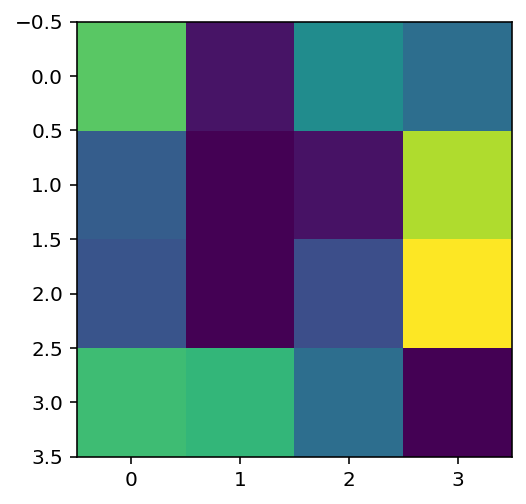

In [71]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [72]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (60, 8192) 	Validation Bottleneck Features: (29, 8192)


## Model 4: Basic Transfer Lerning Neural networks

In [88]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = vgg_model.output_shape[1]
print(vgg_model.output_shape[1])
model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

8192
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [74]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 60 samples, validate on 29 samples
Epoch 1/30
60/60 [==============================] - 1s 15ms/step - loss: 0.9213 - accuracy: 0.4167 - val_loss: 0.5770 - val_accuracy: 0.6207
Epoch 2/30
60/60 [==============================] - 0s 2ms/step - loss: 0.5324 - accuracy: 0.7667 - val_loss: 0.5157 - val_accuracy: 0.8621
Epoch 3/30
60/60 [==============================] - 0s 2ms/step - loss: 0.3858 - accuracy: 0.8500 - val_loss: 0.4725 - val_accuracy: 0.8276
Epoch 4/30
60/60 [==============================] - 0s 2ms/step - loss: 0.3172 - accuracy: 0.8333 - val_loss: 0.5136 - val_accuracy: 0.7241
Epoch 5/30
60/60 [==============================] - 0s 2ms/step - loss: 0.2988 - accuracy: 0.8667 - val_loss: 0.5834 - val_accuracy: 0.6897
Epoch 6/30
60/60 [==============================] - 0s 2ms/step - loss: 0.1552 - accuracy: 1.0000 - val_loss: 0.4020 - val_accuracy: 0.7931
Epoch 7/30
60/60 [==============================] - 0s 2ms/step - loss: 0.1090 - accuracy: 0.9833 - val_loss: 0.359

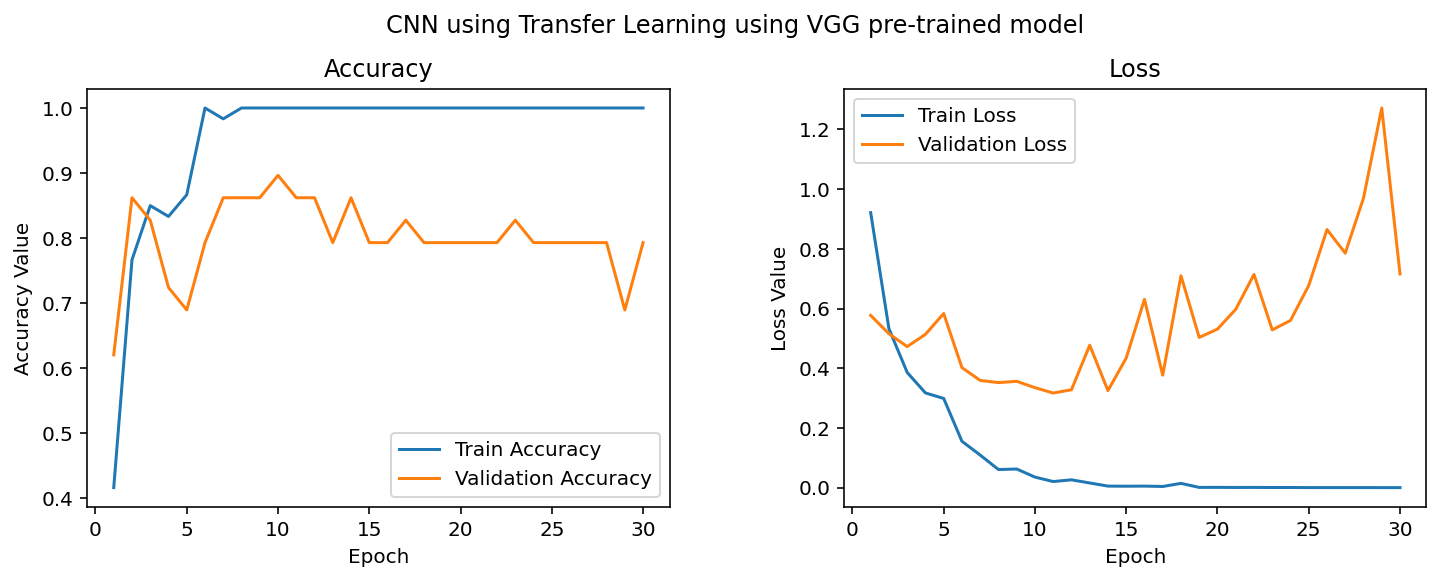

In [75]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN using Transfer Learning using VGG pre-trained model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [76]:
model.save('50cats_dogs_tlearn_basic_cnn.h5')

## Model 5: Data Augmentation with Re-scaling (Normalization) and train model by freezing all weights

In [37]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=5)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=3)

In [38]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
              
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)    

Epoch 1/100
100/100 [==============================] - 142s 1s/step - loss: 0.7160 - accuracy: 0.5360 - val_loss: 0.5857 - val_accuracy: 0.7552
Epoch 2/100
100/100 [==============================] - 141s 1s/step - loss: 0.6172 - accuracy: 0.6420 - val_loss: 0.7702 - val_accuracy: 0.6993
Epoch 3/100
100/100 [==============================] - 142s 1s/step - loss: 0.5580 - accuracy: 0.7300 - val_loss: 0.2374 - val_accuracy: 0.7133
Epoch 4/100
100/100 [==============================] - 141s 1s/step - loss: 0.5082 - accuracy: 0.7600 - val_loss: 0.5397 - val_accuracy: 0.8392
Epoch 5/100
100/100 [==============================] - 141s 1s/step - loss: 0.4431 - accuracy: 0.7940 - val_loss: 0.5695 - val_accuracy: 0.8601
Epoch 6/100
100/100 [==============================] - 141s 1s/step - loss: 0.4027 - accuracy: 0.8420 - val_loss: 0.1447 - val_accuracy: 0.7972
Epoch 7/100
100/100 [==============================] - 141s 1s/step - loss: 0.3928 - accuracy: 0.8220 - val_loss: 0.1441 - val_accuracy:

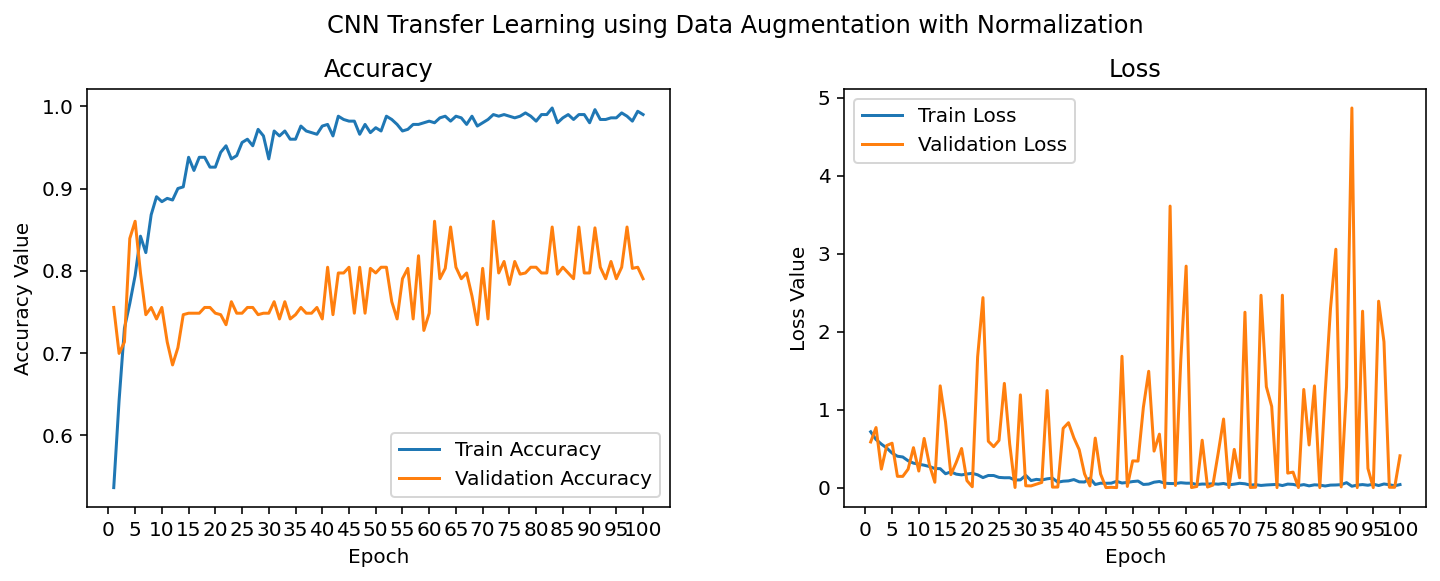

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Transfer Learning using Data Augmentation with Normalization', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [40]:
model.save('50cats_dogs_tlearn_img_aug_cnn.h5')

## Using a Pre-trrainer CNN & clear all weights at 4th and 5th block

In [41]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Layer Type  \
0   <keras.engine.input_layer.InputLayer object at 0x000001DF7570EAC8>   
1   <keras.layers.convolutional.Conv2D object at 0x000001DF7550B8C8>     
2   <keras.layers.convolutional.Conv2D object at 0x000001DF9DC4ADC8>     
3   <keras.layers.pooling.MaxPooling2D object at 0x000001DF758F5188>     
4   <keras.layers.convolutional.Conv2D object at 0x000001DF758F5AC8>     
5   <keras.layers.convolutional.Conv2D object at 0x000001DF75897E48>     
6   <keras.layers.pooling.MaxPooling2D object at 0x000001DF9AB98948>     
7   <keras.layers.convolutional.Conv2D object at 0x000001DF758B4DC8>     
8   <keras.layers.convolutional.Conv2D object at 0x000001DF758ABAC8>     
9   <keras.layers.convolutional.Conv2D object at 0x000001DF7563A608>     
10  <keras.layers.pooling.MaxPooling2D object at 0x000001DF7551A448>     
11  <keras.layers.convolutional.Conv2D object at 0x000001DF754F7B88>     
12  <keras.layers.convolutional.Conv2D object at 0x000001DF9AB8B588>     
13  <keras.layers.convolutional.Conv2D object at 0x000001DF75A18948>     
14  <keras.layers.pooling.MaxPooling2D object at 0x000001DF758C0808>     
15  <keras.layers.convolutional.Conv2D object at 0x000001DF9AB89948>     
16  <keras.layers.convolutional.Conv2D object at 0x000001DF5F50C688>     
17  <keras.layers.convolutional.Conv2D object at 0x000001DF75333E88>     
18  <keras.layers.pooling.MaxPooling2D object at 0x000001DF754BF908>     
19  <keras.layers.core.Flatten object at 0x000001DF758F5D88>             

      Layer Name  Layer Trainable  
0   input_1       False            
1   block1_conv1  False            
2   block1_conv2  False            
3   block1_pool   False            
4   block2_conv1  False            
5   block2_conv2  False            
6   block2_pool   False            
7   block3_conv1  False            
8   block3_conv2  False            
9   block3_conv3  False            
10  block3_pool   False            
11  block4_conv1  True             
12  block4_conv2  True             
13  block4_conv3  True             
14  block4_pool   True             
15  block5_conv1  True             
16  block5_conv2  True             
17  block5_conv3  True             
18  block5_pool   True             
19  flatten_4     True

## Model 6: Tranfer Lerning CNN, DataAugmentation, clean weighs at 4th & 5th layers blocks (fine tunning)

In [42]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])
              
history = model.fit_generator(train_generator, steps_per_epoch=50, epochs=70,
                              validation_data=val_generator, validation_steps=8, 
                              verbose=1)              

Epoch 1/70
50/50 [==============================] - 462s 9s/step - loss: 0.6130 - accuracy: 0.6627 - val_loss: 0.4272 - val_accuracy: 0.7500
Epoch 2/70
50/50 [==============================] - 460s 9s/step - loss: 0.3192 - accuracy: 0.8693 - val_loss: 0.3022 - val_accuracy: 0.8500
Epoch 3/70
50/50 [==============================] - 460s 9s/step - loss: 0.1568 - accuracy: 0.9487 - val_loss: 0.3895 - val_accuracy: 0.8000
Epoch 4/70
50/50 [==============================] - 461s 9s/step - loss: 0.0933 - accuracy: 0.9693 - val_loss: 0.3768 - val_accuracy: 0.9000
Epoch 5/70
50/50 [==============================] - 461s 9s/step - loss: 0.0637 - accuracy: 0.9787 - val_loss: 0.4260 - val_accuracy: 0.9000
Epoch 6/70
50/50 [==============================] - 460s 9s/step - loss: 0.0379 - accuracy: 0.9873 - val_loss: 0.6624 - val_accuracy: 0.8500
Epoch 7/70
50/50 [==============================] - 461s 9s/step - loss: 0.0286 - accuracy: 0.9927 - val_loss: 3.4762 - val_accuracy: 0.6500
Epoch 8/70
50

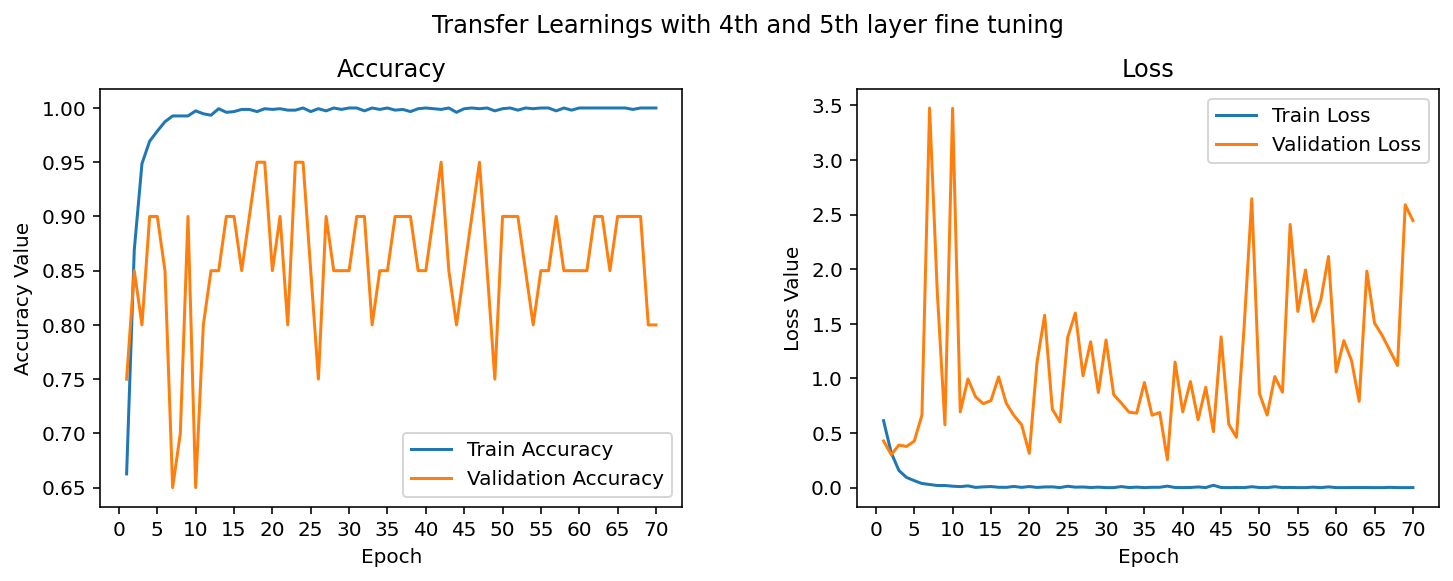

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Transfer Learnings with 4th and 5th layer fine tuning', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,71))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 71, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 71, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [44]:
model.save('50cats_dogs_tlearn_finetune_img_aug_cnn.h5')

## Benchmarking between this 5 models

In [77]:
# load dependencies
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
import model_evaluation_utils as meu
%matplotlib inline

# load saved models
basic_cnn_wo_dropout = load_model('50cats_dogs_basic_without_dropout.h5')
basic_cnn = load_model('50cats_dogs_basic_cnn.h5')
img_aug_cnn = load_model('50cats_dogs_cnn_img_aug.h5')
tl_cnn = load_model('50cats_dogs_tlearn_basic_cnn.h5')
tl_img_aug_cnn = load_model('50cats_dogs_tlearn_img_aug_cnn.h5')
tl_img_aug_finetune_cnn = load_model('50cats_dogs_tlearn_finetune_img_aug_cnn.h5')

# load other configurations
IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
num2class_label_transformer = lambda l: ['cat' if x == 0 else 'dog' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'cat' else 1 for x in l]

# load VGG model for bottleneck features
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                  input_shape=input_shape)
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [55]:
IMG_DIM = (150, 150)

test_files = glob.glob('50test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in test_files]

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255
test_labels_enc = class2num_label_transformer(test_labels)

print('Test dataset shape:', test_imgs.shape)
print(test_labels[0:5], test_labels_enc[0:5])

Test dataset shape: (36, 150, 150, 3)
['cat', 'cat', 'cat', 'cat', 'cat'] [0, 0, 0, 0, 0]


## Model 1: Basic CNN without Dropout

In [79]:
predictions = basic_cnn_wo_dropout.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.5517
Precision: 0.5552
Recall: 0.5517
F1 Score: 0.5528

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.50      0.54      0.52        13
         dog       0.60      0.56      0.58        16

    accuracy                           0.55        29
   macro avg       0.55      0.55      0.55        29
weighted avg       0.56      0.55      0.55        29


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   cat dog
Actual: cat  7          6 
        dog  7          9 


C:\Users\svbhavsar\Downloads\model_evaluation_utils.py:57: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
C:\Users\svbhavsar\Downloads\model_evaluation_utils.py:59: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


## Model 2: Basic CNN with Dropout

In [80]:
predictions = basic_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.5172
Precision: 0.5245
Recall: 0.5172
F1 Score: 0.5184

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.47      0.54      0.50        13
         dog       0.57      0.50      0.53        16

    accuracy                           0.52        29
   macro avg       0.52      0.52      0.52        29
weighted avg       0.52      0.52      0.52        29


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   cat dog
Actual: cat  7          6 
        dog  8          8 


## Model 3: CNN with Data Augumentation

In [81]:
predictions = img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.6207
Precision: 0.6217
Recall: 0.6207
F1 Score: 0.6012

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.62      0.38      0.48        13
         dog       0.62      0.81      0.70        16

    accuracy                           0.62        29
   macro avg       0.62      0.60      0.59        29
weighted avg       0.62      0.62      0.60        29


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   cat dog
Actual: cat  5          8 
        dog  3          13


## Model 4: Basic Transfer Learning

In [82]:
test_bottleneck_features = get_bottleneck_features(vgg_model, test_imgs_scaled)

predictions = tl_cnn.predict_classes(test_bottleneck_features, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.8621
Precision: 0.8897
Recall: 0.8621
F1 Score: 0.8572

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       1.00      0.69      0.82        13
         dog       0.80      1.00      0.89        16

    accuracy                           0.86        29
   macro avg       0.90      0.85      0.85        29
weighted avg       0.89      0.86      0.86        29


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   cat dog
Actual: cat  9          4 
        dog  0          16


## Model 5: Transfer Learning with Data Augumentation and freezing all weights

In [83]:
predictions = tl_img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.8276
Precision: 0.8686
Recall: 0.8276
F1 Score: 0.8187

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       1.00      0.62      0.76        13
         dog       0.76      1.00      0.86        16

    accuracy                           0.83        29
   macro avg       0.88      0.81      0.81        29
weighted avg       0.87      0.83      0.82        29


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   cat dog
Actual: cat  8          5 
        dog  0          16


## Model 6: Transfer Learning with Data Augumentation and unfrreezing weights at 5th and 6th block

In [84]:
predictions = tl_img_aug_finetune_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.7931
Precision: 0.8123
Recall: 0.7931
F1 Score: 0.7858

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.89      0.62      0.73        13
         dog       0.75      0.94      0.83        16

    accuracy                           0.79        29
   macro avg       0.82      0.78      0.78        29
weighted avg       0.81      0.79      0.79        29


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   cat dog
Actual: cat  8          5 
        dog  1          15


In [120]:
# load dependencies
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
import model_evaluation_utils as meu
%matplotlib inline

# load saved models
tl_cnn_vgg19 = load_model('50cats_dogs_tlearn_basic_cnn_vgg19.h5')

# load other configurations
IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
num2class_label_transformer = lambda l: ['cat' if x == 0 else 'dog' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'cat' else 1 for x in l]

# load VGG model for bottleneck features
from keras.applications import vgg19
from keras.models import Model
import keras

vgg = vgg19.VGG19(include_top=False, weights='imagenet', 
                  input_shape=input_shape)
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [121]:
test_bottleneck_features = get_bottleneck_features(vgg_model, test_imgs_scaled)

predictions = tl_cnn_vgg19.predict_classes(test_bottleneck_features, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.7931
Precision: 0.7931
Recall: 0.7931
F1 Score: 0.7931

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.77      0.77      0.77        13
         dog       0.81      0.81      0.81        16

    accuracy                           0.79        29
   macro avg       0.79      0.79      0.79        29
weighted avg       0.79      0.79      0.79        29


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   cat dog
Actual: cat  10         3 
        dog  3          13


## Worst Model - Model 1 - Basic CNN 

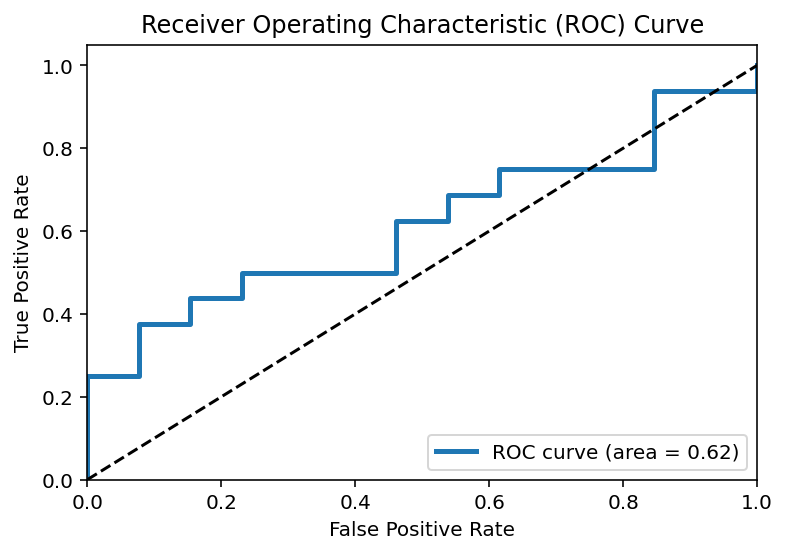

In [85]:
meu.plot_model_roc_curve(basic_cnn_wo_dropout, test_imgs_scaled, 
                         true_labels=test_labels_enc, 
                         class_names=[0, 1]) 

## Best model - Model 4 - Basic Transfer Learning

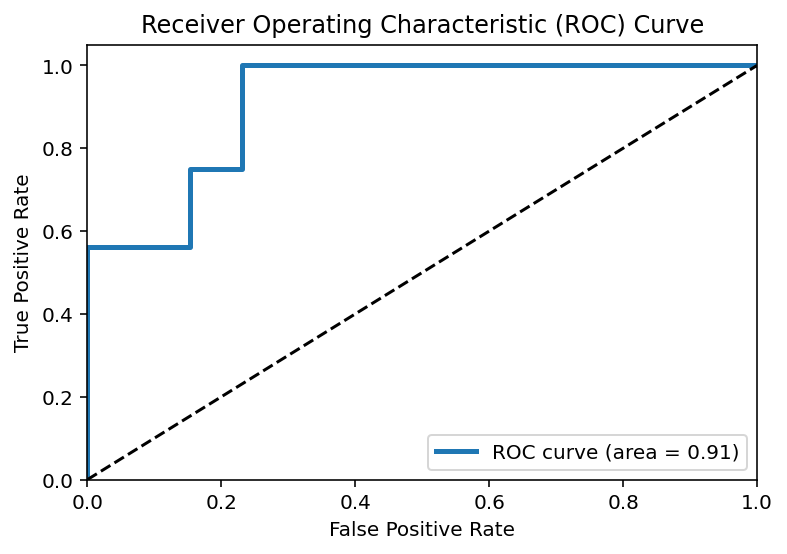

In [89]:
# best model - basic transfer learning
meu.plot_model_roc_curve(tl_cnn, get_bottleneck_features(vgg_model, test_imgs_scaled), 
                         true_labels=test_labels_enc, 
                         class_names=[0, 1])

In [91]:
predictions = tl_cnn.predict_classes(test_bottleneck_features, verbose=0)
predictions = num2class_label_transformer(predictions)

In [92]:
meu.display_confusion_matrix(true_labels=test_labels, 
                                    predicted_labels=predictions, 
                                    classes=['dog','cat'])

            Predicted:    
                   dog cat
Actual: dog  16         0 
        cat  4          9 


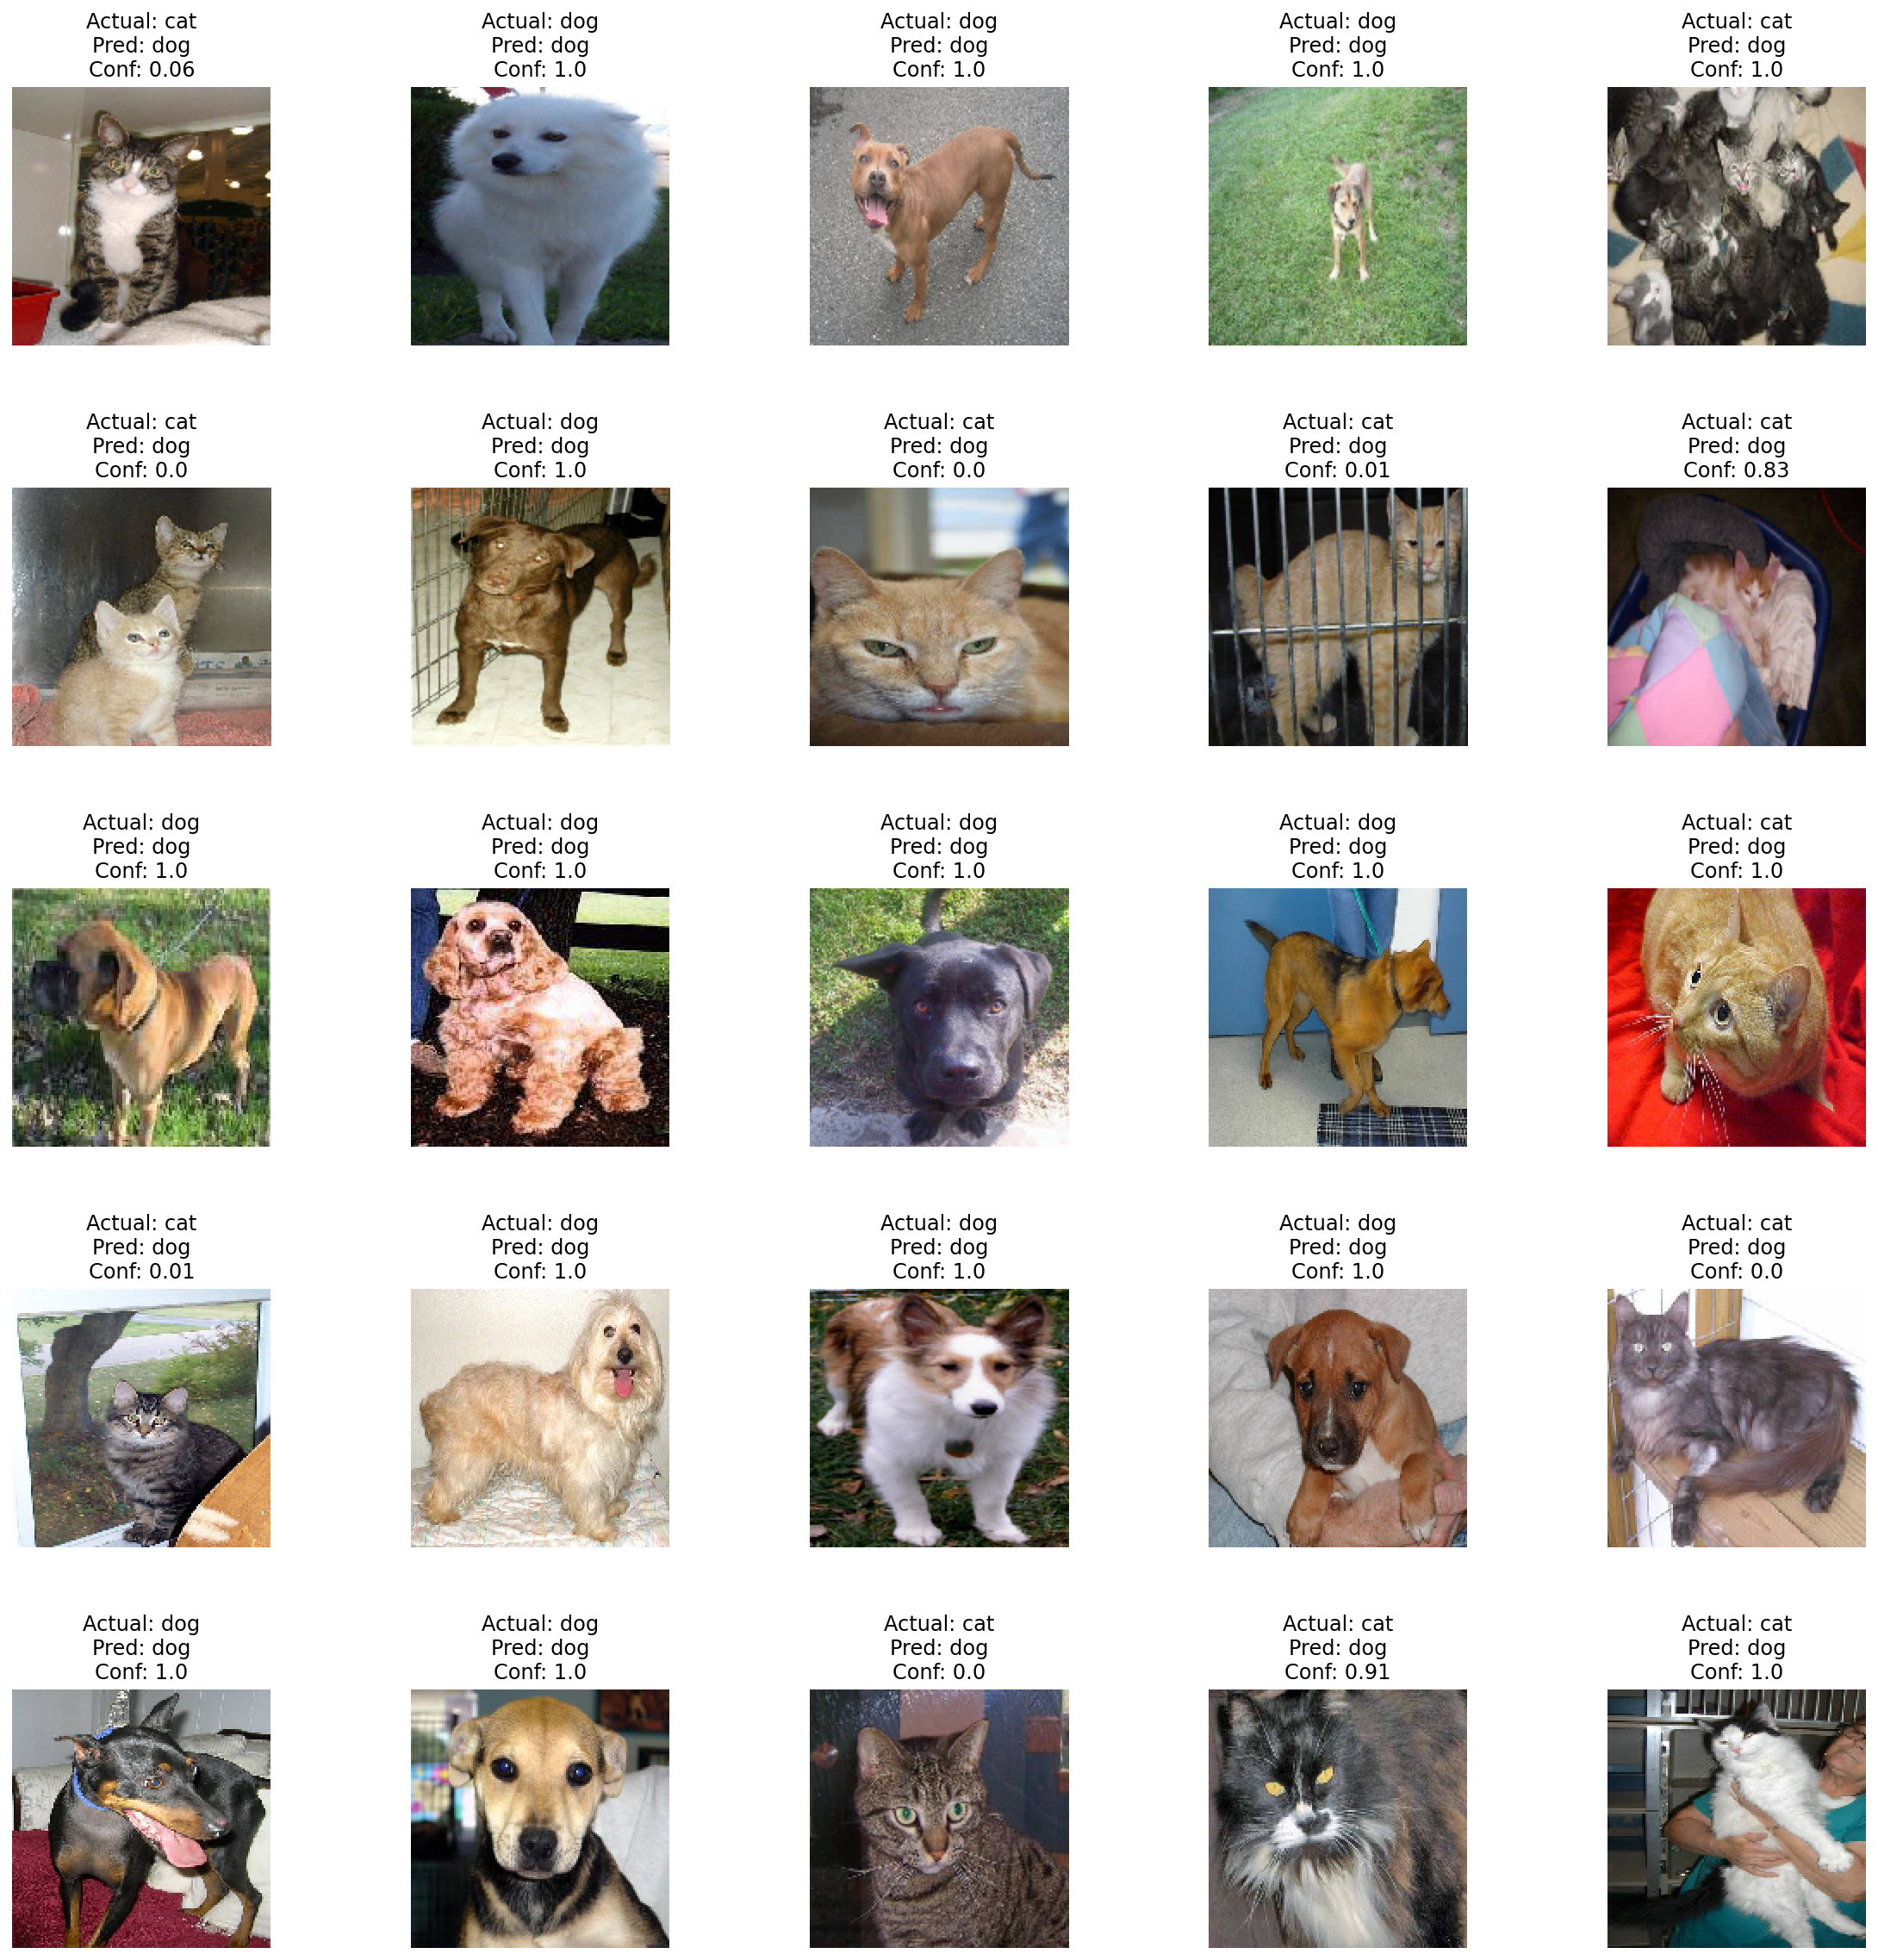

In [96]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)
batch_size = 25
dataset = test_imgs_scaled
model = tl_img_aug_cnn

label_dict = dict(enumerate(['dog','cat']))
model_input_shape = (1,)+model.get_input_shape_at(0)[1:]
random_batch_indx = np.random.permutation(np.arange(0,len(dataset)))[:batch_size]

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual_label = np.array(test_labels)[random_batch_indx[img_idx]]
        prediction = model.predict(dataset[random_batch_indx[img_idx]].reshape(model_input_shape))[0]
        label_idx = np.argmax(prediction)
        predicted_label = label_dict.get(label_idx)
        conf = round(prediction[label_idx], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+actual_label+'\nPred: '+predicted_label + '\nConf: ' +str(conf))
        ax[i][j].imshow(dataset[random_batch_indx[img_idx]])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)


In [111]:
from keras.applications import vgg19
from keras.models import Model
import keras

vgg = vgg19.VGG19(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

80142336/80134624 [==============================] - 6s 0us/step


Layer Type  \
0   <keras.engine.input_layer.InputLayer object at 0x0000024BFF970C08>   
1   <keras.layers.convolutional.Conv2D object at 0x0000024BA67B7748>     
2   <keras.layers.convolutional.Conv2D object at 0x0000024CA3FD9BC8>     
3   <keras.layers.pooling.MaxPooling2D object at 0x0000024C3AE36C88>     
4   <keras.layers.convolutional.Conv2D object at 0x0000024C3CBFA308>     
5   <keras.layers.convolutional.Conv2D object at 0x0000024CA3FE2A08>     
6   <keras.layers.pooling.MaxPooling2D object at 0x0000024C3AE6AFC8>     
7   <keras.layers.convolutional.Conv2D object at 0x0000024C3AE6A608>     
8   <keras.layers.convolutional.Conv2D object at 0x0000024C3AE69948>     
9   <keras.layers.convolutional.Conv2D object at 0x0000024BFD49FF48>     
10  <keras.layers.convolutional.Conv2D object at 0x0000024BFD49BC88>     
11  <keras.layers.pooling.MaxPooling2D object at 0x0000024BFD497F88>     
12  <keras.layers.convolutional.Conv2D object at 0x0000024BFD480148>     
13  <keras.layers.convolutional.Conv2D object at 0x0000024BFD4827C8>     
14  <keras.layers.convolutional.Conv2D object at 0x0000024BFD484088>     
15  <keras.layers.convolutional.Conv2D object at 0x0000024B9F8A4E48>     
16  <keras.layers.pooling.MaxPooling2D object at 0x0000024B9F883F88>     
17  <keras.layers.convolutional.Conv2D object at 0x0000024B9F883148>     
18  <keras.layers.convolutional.Conv2D object at 0x0000024B9F891A48>     
19  <keras.layers.convolutional.Conv2D object at 0x0000024B9F88FD48>     
20  <keras.layers.convolutional.Conv2D object at 0x0000024B9F88EEC8>     
21  <keras.layers.pooling.MaxPooling2D object at 0x0000024B9F87C788>     
22  <keras.layers.core.Flatten object at 0x0000024B9F873D88>             

      Layer Name  Layer Trainable  
0   input_10      False            
1   block1_conv1  False            
2   block1_conv2  False            
3   block1_pool   False            
4   block2_conv1  False            
5   block2_conv2  False            
6   block2_pool   False            
7   block3_conv1  False            
8   block3_conv2  False            
9   block3_conv3  False            
10  block3_conv4  False            
11  block3_pool   False            
12  block4_conv1  False            
13  block4_conv2  False            
14  block4_conv3  False            
15  block4_conv4  False            
16  block4_pool   False            
17  block5_conv1  False            
18  block5_conv2  False            
19  block5_conv3  False            
20  block5_conv4  False            
21  block5_pool   False            
22  flatten_7     False

## VVG19 feature extraction

(1, 4, 4, 512)


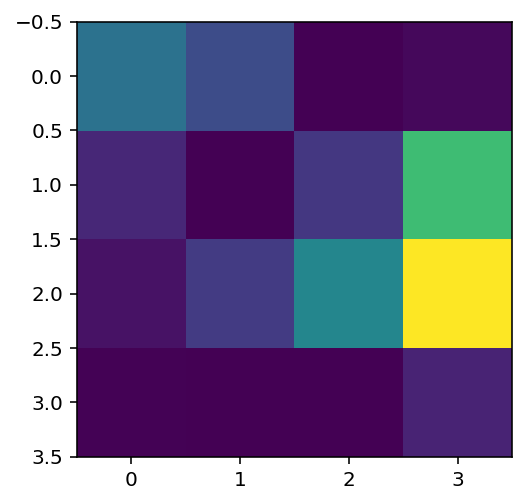

In [112]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [113]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (60, 8192) 	Validation Bottleneck Features: (29, 8192)


## Model 4: Basic Transfer Lerning Neural networks

In [114]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = vgg_model.output_shape[1]
print(vgg_model.output_shape[1])
model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

8192
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [115]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 60 samples, validate on 29 samples
Epoch 1/30
60/60 [==============================] - 1s 14ms/step - loss: 0.7793 - accuracy: 0.5833 - val_loss: 0.6401 - val_accuracy: 0.6207
Epoch 2/30
60/60 [==============================] - 0s 3ms/step - loss: 0.5118 - accuracy: 0.7333 - val_loss: 0.6022 - val_accuracy: 0.6552
Epoch 3/30
60/60 [==============================] - 0s 2ms/step - loss: 0.4610 - accuracy: 0.7500 - val_loss: 0.6025 - val_accuracy: 0.6207
Epoch 4/30
60/60 [==============================] - 0s 2ms/step - loss: 0.3191 - accuracy: 0.9000 - val_loss: 0.6331 - val_accuracy: 0.6552
Epoch 5/30
60/60 [==============================] - 0s 2ms/step - loss: 0.2910 - accuracy: 0.8500 - val_loss: 0.6001 - val_accuracy: 0.6552
Epoch 6/30
60/60 [==============================] - 0s 2ms/step - loss: 0.2377 - accuracy: 0.9000 - val_loss: 0.6437 - val_accuracy: 0.6552
Epoch 7/30
60/60 [==============================] - 0s 2ms/step - loss: 0.1404 - accuracy: 0.9500 - val_loss: 0.650

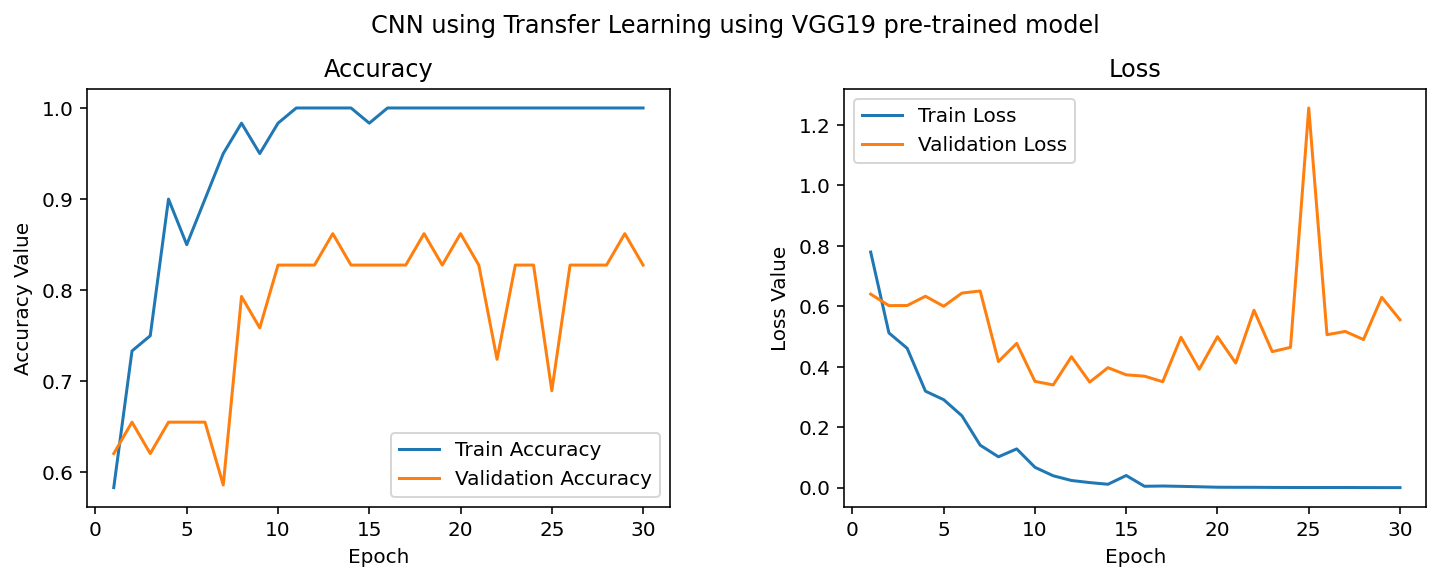

In [116]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN using Transfer Learning using VGG19 pre-trained model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [117]:
model.save('50cats_dogs_tlearn_basic_cnn_vgg19.h5')

In [18]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(150,150,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output=output)
for layer in restnet.layers:
    layer.trainable = False
restnet.summary() 

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

C:\Users\svbhavsar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  import sys


## ResNet50 feature extraction

(1, 5, 5, 2048)


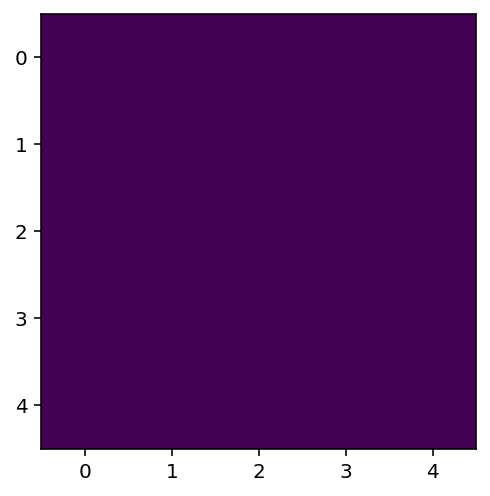

In [124]:
bottleneck_feature_example = res.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [125]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_res = get_bottleneck_features(res_model, train_imgs_scaled)
validation_features_res = get_bottleneck_features(res_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_res.shape, 
      '\tValidation Bottleneck Features:', validation_features_res.shape)

Train Bottleneck Features: (60, 51200) 	Validation Bottleneck Features: (29, 51200)


## Model 4: Basic Transfer Lerning Neural networks

In [19]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
model = Sequential()
model.add(restnet)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 51200)             23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 50,065,793
Trainable params: 26,478,081
Non-trainable params: 23,587,712
_________________________________

In [45]:

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)

Epoch 1/30
100/100 [==============================] - 16s 164ms/step - loss: 0.6686 - accuracy: 0.6020 - val_loss: 0.7032 - val_accuracy: 0.5616
Epoch 2/30
100/100 [==============================] - 17s 171ms/step - loss: 0.6531 - accuracy: 0.6260 - val_loss: 0.7920 - val_accuracy: 0.6164
Epoch 3/30
100/100 [==============================] - 17s 170ms/step - loss: 0.6149 - accuracy: 0.6600 - val_loss: 0.4565 - val_accuracy: 0.6301
Epoch 4/30
100/100 [==============================] - 16s 163ms/step - loss: 0.6060 - accuracy: 0.6800 - val_loss: 1.6110 - val_accuracy: 0.5616
Epoch 5/30
100/100 [==============================] - 16s 165ms/step - loss: 0.5529 - accuracy: 0.7320 - val_loss: 0.4092 - val_accuracy: 0.6301
Epoch 6/30
100/100 [==============================] - 17s 168ms/step - loss: 0.5430 - accuracy: 0.7380 - val_loss: 0.2663 - val_accuracy: 0.5931
Epoch 7/30
100/100 [==============================] - 17s 168ms/step - loss: 0.5058 - accuracy: 0.7500 - val_loss: 0.1460 - val_ac

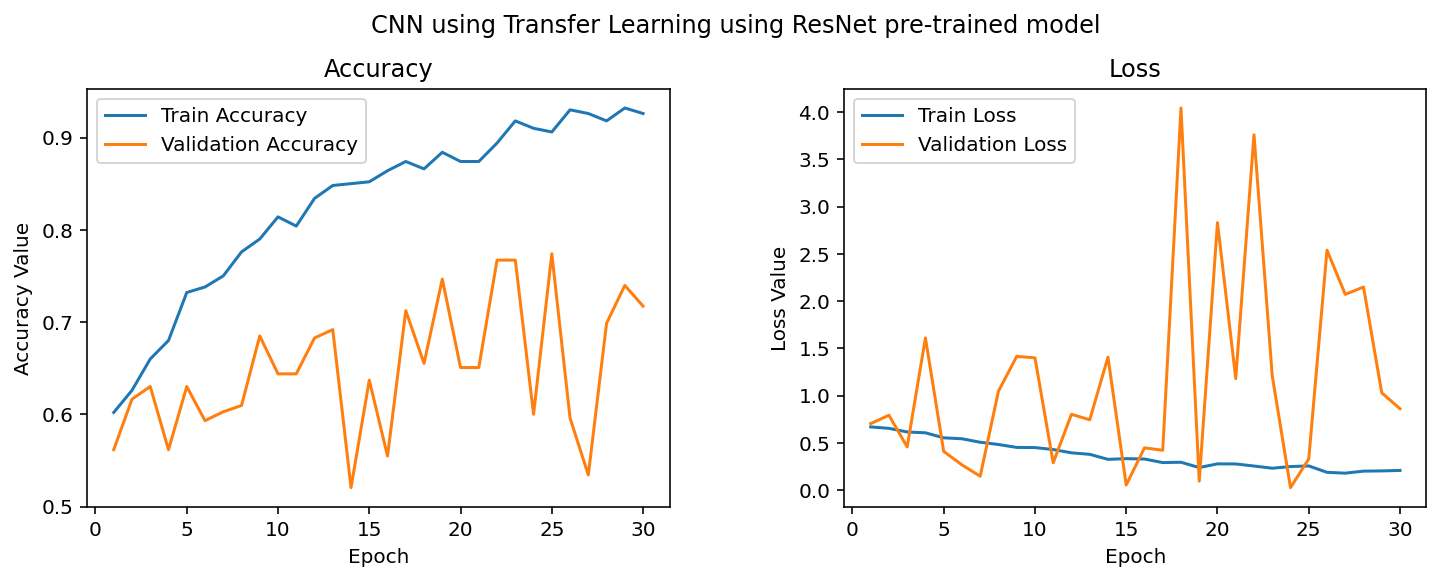

In [50]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN using Transfer Learning using ResNet pre-trained model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [51]:
model.save('50cats_dogs_tlearn_basic_cnn_res.h5')

In [53]:
# load dependencies
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
import model_evaluation_utils as meu
%matplotlib inline

# load saved models
tl_cnn_res = load_model('50cats_dogs_tlearn_basic_cnn_res.h5')

# load other configurations
IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
num2class_label_transformer = lambda l: ['cat' if x == 0 else 'dog' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'cat' else 1 for x in l]

# load VGG model for bottleneck features
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras

res = ResNet50(include_top=False, weights='imagenet', 
                  input_shape=input_shape)
output = res.layers[-1].output
output = keras.layers.Flatten()(output)
res_model = Model(res.input, output)
res_model.trainable = False


C:\Users\svbhavsar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [56]:

predictions = tl_cnn_res.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.7222
Precision: 0.737
Recall: 0.7222
F1 Score: 0.7205

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.67      0.82      0.74        17
         cat       0.80      0.63      0.71        19

    accuracy                           0.72        36
   macro avg       0.73      0.73      0.72        36
weighted avg       0.74      0.72      0.72        36


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   dog cat
Actual: dog  14         3 
        cat  7          12


C:\Users\svbhavsar\Downloads\model_evaluation_utils.py:57: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
C:\Users\svbhavsar\Downloads\model_evaluation_utils.py:59: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


## Inception V3

In [73]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
import keras

incep = InceptionV3(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = incep.layers[-1].output
output = keras.layers.Flatten()(output)
incep_model = Model(incep.input, output)

incep_model.trainable = False
for layer in incep_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in incep_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

Layer Type  \
0    <keras.engine.input_layer.InputLayer object at 0x000001C583EFD5C8>             
1    <keras.layers.convolutional.Conv2D object at 0x000001C583EFDEC8>               
2    <keras.layers.normalization.BatchNormalization object at 0x000001C583EFD0C8>   
3    <keras.layers.core.Activation object at 0x000001C583EFD3C8>                    
4    <keras.layers.convolutional.Conv2D object at 0x000001C583F24D08>               
..                                                                ...               
307  <keras.layers.merge.Concatenate object at 0x000001C5888F8948>                  
308  <keras.layers.merge.Concatenate object at 0x000001C588A27AC8>                  
309  <keras.layers.core.Activation object at 0x000001C588A71E48>                    
310  <keras.layers.merge.Concatenate object at 0x000001C588A71188>                  
311  <keras.layers.core.Flatten object at 0x000001C588AEC788>                       

                  Layer Name  Layer Trainable  
0    input_11                 False            
1    conv2d_389               False            
2    batch_normalization_377  False            
3    activation_597           False            
4    conv2d_390               False            
..          ...                 ...            
307  mixed9_1                 False            
308  concatenate_10           False            
309  activation_690           False            
310  mixed10                  False            
311  flatten_13               False            

[312 rows x 3 columns]

(1, 3, 3, 2048)


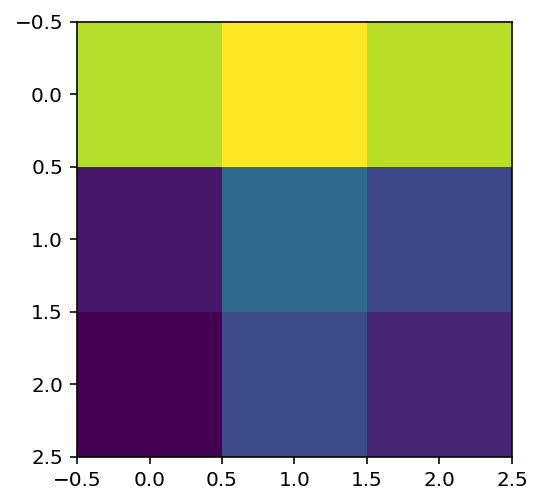

In [76]:
bottleneck_feature_example = incep.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [77]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_incep = get_bottleneck_features(incep_model, train_imgs_scaled)
validation_features_incep = get_bottleneck_features(incep_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_incep.shape, 
      '\tValidation Bottleneck Features:', validation_features_incep.shape)

Train Bottleneck Features: (60, 18432) 	Validation Bottleneck Features: (35, 18432)


## Model 4: Basic Transfer Lerning Neural networks

In [78]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = incep_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 512)               9437696   
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 513       
Total params: 9,700,865
Trainable params: 9,700,865
Non-trainable params: 0
_________________________________________________________________


In [79]:
history = model.fit(x=train_features_incep, y=train_labels_enc,
                    validation_data=(validation_features_incep, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 60 samples, validate on 35 samples
Epoch 1/30
60/60 [==============================] - 1s 19ms/step - loss: 2.6927 - accuracy: 0.6000 - val_loss: 0.1864 - val_accuracy: 0.8857
Epoch 2/30
60/60 [==============================] - 0s 8ms/step - loss: 0.2847 - accuracy: 0.9000 - val_loss: 0.0609 - val_accuracy: 1.0000
Epoch 3/30
60/60 [==============================] - 1s 9ms/step - loss: 0.2399 - accuracy: 0.9000 - val_loss: 0.2599 - val_accuracy: 0.8571
Epoch 4/30
60/60 [==============================] - 1s 9ms/step - loss: 0.4470 - accuracy: 0.9167 - val_loss: 0.1149 - val_accuracy: 0.9143
Epoch 5/30
60/60 [==============================] - 1s 9ms/step - loss: 0.1662 - accuracy: 0.9500 - val_loss: 0.0927 - val_accuracy: 0.9429
Epoch 6/30
60/60 [==============================] - 1s 9ms/step - loss: 0.1646 - accuracy: 0.9500 - val_loss: 1.2241 - val_accuracy: 0.7714
Epoch 7/30
60/60 [==============================] - 1s 10ms/step - loss: 0.2440 - accuracy: 0.9500 - val_loss: 0.09

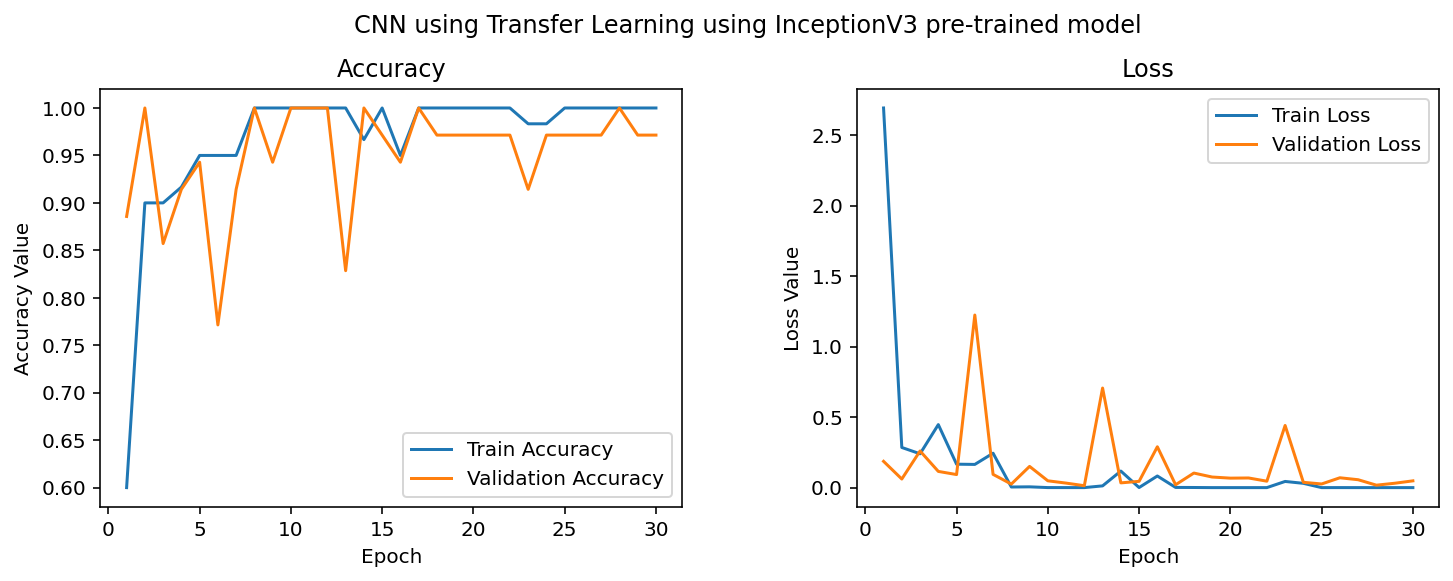

In [80]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN using Transfer Learning using InceptionV3 pre-trained model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [81]:
model.save('50cats_dogs_tlearn_basic_cnn_incep.h5')

In [82]:
# load dependencies
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
import model_evaluation_utils as meu
%matplotlib inline

# load saved models
tl_cnn_incep = load_model('50cats_dogs_tlearn_basic_cnn_incep.h5')

# load other configurations
IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
num2class_label_transformer = lambda l: ['cat' if x == 0 else 'dog' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'cat' else 1 for x in l]

# load VGG model for bottleneck features
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
import keras

incep = InceptionV3(include_top=False, weights='imagenet', 
                  input_shape=input_shape)
output = incep.layers[-1].output
output = keras.layers.Flatten()(output)
incep_model = Model(incep.input, output)
incep_model.trainable = False


In [84]:
test_bottleneck_features = get_bottleneck_features(incep_model, test_imgs_scaled)

predictions = tl_cnn_incep.predict_classes(test_bottleneck_features, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.9444
Precision: 0.9503
Recall: 0.9444
F1 Score: 0.9444

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.89      1.00      0.94        17
         cat       1.00      0.89      0.94        19

    accuracy                           0.94        36
   macro avg       0.95      0.95      0.94        36
weighted avg       0.95      0.94      0.94        36


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   dog cat
Actual: dog  17         0 
        cat  2          17


C:\Users\svbhavsar\Downloads\model_evaluation_utils.py:57: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
C:\Users\svbhavsar\Downloads\model_evaluation_utils.py:59: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


## Xception

In [85]:
from keras.applications.xception import Xception
from keras.models import Model
import keras

xcep = Xception(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = xcep.layers[-1].output
output = keras.layers.Flatten()(output)
xcep_model = Model(xcep.input, output)

xcep_model.trainable = False
for layer in xcep_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in xcep_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

83689472/83683744 [==============================] - 2s 0us/step


Layer Type  \
0    <keras.engine.input_layer.InputLayer object at 0x000001C5AF683808>             
1    <keras.layers.convolutional.Conv2D object at 0x000001C5AF683A88>               
2    <keras.layers.normalization.BatchNormalization object at 0x000001C5AF686108>   
3    <keras.layers.core.Activation object at 0x000001C5AF686C08>                    
4    <keras.layers.convolutional.Conv2D object at 0x000001C5AF6B2908>               
..                                                                ...               
128  <keras.layers.core.Activation object at 0x000001C5F74E9F48>                    
129  <keras.layers.convolutional.SeparableConv2D object at 0x000001C5F74F00C8>      
130  <keras.layers.normalization.BatchNormalization object at 0x000001C5F7506508>   
131  <keras.layers.core.Activation object at 0x000001C5F753DEC8>                    
132  <keras.layers.core.Flatten object at 0x000001C5F729C048>                       

               Layer Name  Layer Trainable  
0    input_15              False            
1    block1_conv1          False            
2    block1_conv1_bn       False            
3    block1_conv1_act      False            
4    block1_conv2          False            
..            ...            ...            
128  block14_sepconv1_act  False            
129  block14_sepconv2      False            
130  block14_sepconv2_bn   False            
131  block14_sepconv2_act  False            
132  flatten_15            False            

[133 rows x 3 columns]

(1, 5, 5, 2048)


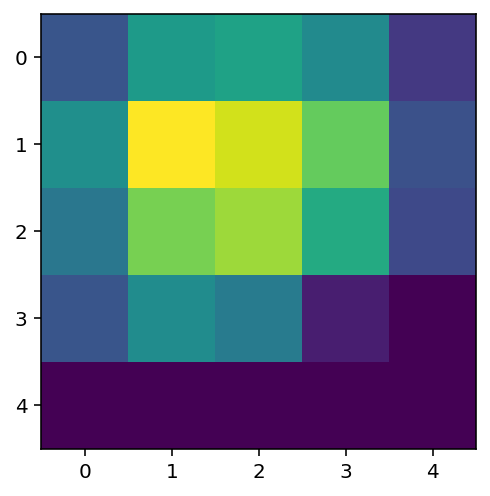

In [86]:
bottleneck_feature_example = xcep.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [87]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_xcep = get_bottleneck_features(xcep_model, train_imgs_scaled)
validation_features_xcep = get_bottleneck_features(xcep_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_xcep.shape, 
      '\tValidation Bottleneck Features:', validation_features_xcep.shape)

Train Bottleneck Features: (60, 51200) 	Validation Bottleneck Features: (35, 51200)


## Model 4: Basic Transfer Lerning Neural networks

In [88]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = xcep_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 512)               26214912  
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 513       
Total params: 26,478,081
Trainable params: 26,478,081
Non-trainable params: 0
_________________________________________________________________


In [89]:
history = model.fit(x=train_features_xcep, y=train_labels_enc,
                    validation_data=(validation_features_xcep, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 60 samples, validate on 35 samples
Epoch 1/30
60/60 [==============================] - 2s 31ms/step - loss: 1.4049 - accuracy: 0.6833 - val_loss: 0.0855 - val_accuracy: 0.9429
Epoch 2/30
60/60 [==============================] - 1s 19ms/step - loss: 0.0504 - accuracy: 0.9833 - val_loss: 0.1271 - val_accuracy: 0.9143
Epoch 3/30
60/60 [==============================] - 1s 20ms/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 0.0648 - val_accuracy: 0.9714
Epoch 4/30
60/60 [==============================] - 1s 20ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.1312 - val_accuracy: 0.9143
Epoch 5/30
60/60 [==============================] - 1s 21ms/step - loss: 0.0268 - accuracy: 0.9833 - val_loss: 0.2419 - val_accuracy: 0.9143
Epoch 6/30
60/60 [==============================] - 1s 20ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.4676 - val_accuracy: 0.9143
Epoch 7/30
60/60 [==============================] - 1s 19ms/step - loss: 0.0301 - accuracy: 0.9833 - val_loss:

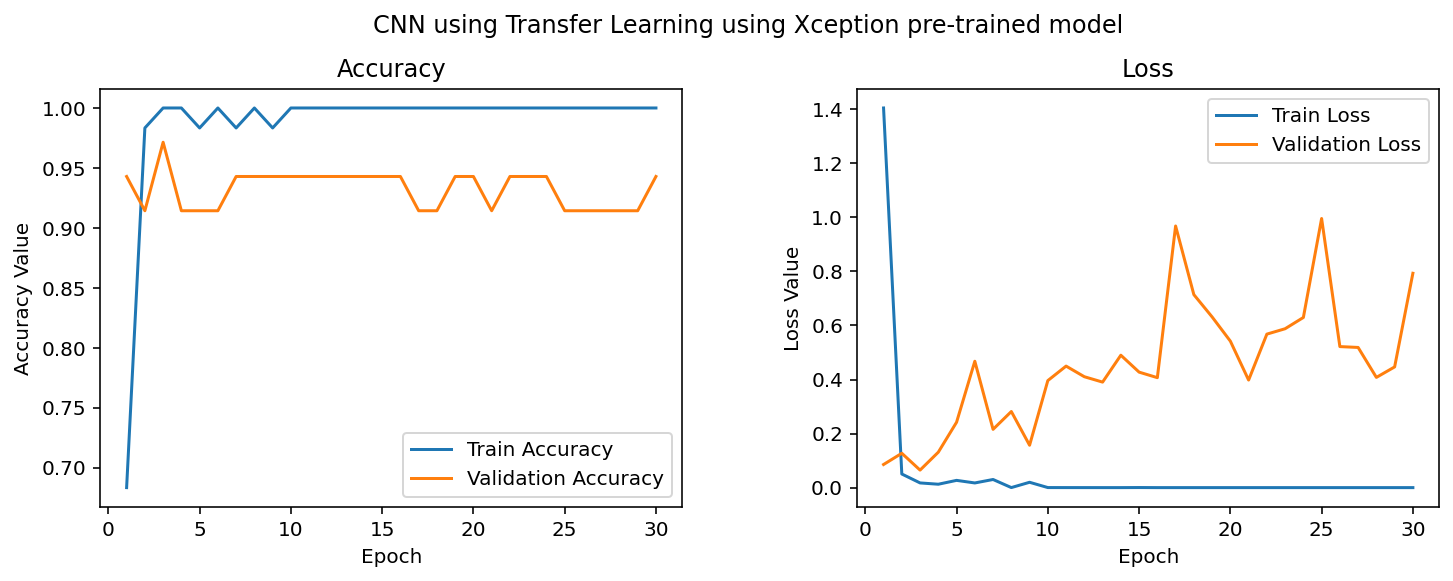

In [90]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN using Transfer Learning using Xception pre-trained model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [91]:
model.save('50cats_dogs_tlearn_basic_cnn_xcep.h5')

In [92]:
# load dependencies
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
import model_evaluation_utils as meu
%matplotlib inline

# load saved models
tl_cnn_xcep = load_model('50cats_dogs_tlearn_basic_cnn_xcep.h5')

# load other configurations
IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
num2class_label_transformer = lambda l: ['cat' if x == 0 else 'dog' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'cat' else 1 for x in l]

# load VGG model for bottleneck features
from keras.applications.xception import Xception
from keras.models import Model
import keras

xcep = Xception(include_top=False, weights='imagenet', 
                  input_shape=input_shape)
output = xcep.layers[-1].output
output = keras.layers.Flatten()(output)
xcep_model = Model(xcep.input, output)
xcep_model.trainable = False


In [93]:
test_bottleneck_features = get_bottleneck_features(xcep_model, test_imgs_scaled)

predictions = tl_cnn_xcep.predict_classes(test_bottleneck_features, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.9167
Precision: 0.9292
Recall: 0.9167
F1 Score: 0.9165

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.85      1.00      0.92        17
         cat       1.00      0.84      0.91        19

    accuracy                           0.92        36
   macro avg       0.93      0.92      0.92        36
weighted avg       0.93      0.92      0.92        36


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   dog cat
Actual: dog  17         0 
        cat  3          16
